In [1]:
import sys
sys.path.append('../utils')
import os

# Importing importlib for module reloading
import importlib
import image_cropp_utils

# Reloading the module
importlib.reload(image_cropp_utils)
from image_cropp_utils import load_dataframe, get_barcode_coordinates, calculate_one_micron, read_microns_per_pixel


In [2]:
df = load_dataframe('../data/raw/p5/binned_outputs/square_002um/spatial/tissue_positions.parquet')

In [3]:
json_path = '/Users/lollijagladiseva/Desktop/cellseg_visium_hd/data/raw/p5/binned_outputs/square_002um/spatial/scalefactors_json.json'
microns_per_pixel = read_microns_per_pixel(json_path)

In [4]:
one_micron = calculate_one_micron(microns_per_pixel)

In [5]:
first_barcode_pxl_row, first_barcode_pxl_col, last_barcode_pxl_row, last_barcode_pxl_col = get_barcode_coordinates(df, one_micron)

In [6]:
import scanpy as sc

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import anndata
import geopandas as gpd

from stardist.models import StarDist2D

from tifffile import imread, imwrite
from csbdeep.utils import normalize
from shapely.geometry import Polygon, Point
from scipy import sparse
from matplotlib.colors import ListedColormap

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

2024-08-18 12:19:26.975460: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
# Load the image file
# Change dir_base as needed to the directory where the downloaded example data is stored
dir_base = '../data/raw/p5/'
filename = 'Visium_HD_Human_Colon_Cancer_P5_tissue_image.btf'
img = imread(dir_base + filename)

# Load the pretrained model
model = StarDist2D.from_pretrained('2D_versatile_he')

# Percentile normalization of the image
# Adjust min_percentile and max_percentile as needed
min_percentile = 5
max_percentile = 95
img = normalize(img, min_percentile, max_percentile)



Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


In [14]:
output_dir = '../data/processed/p5_stardist_whole/'
output_filename = 'normalized_image.tiff'
output_path = output_dir + output_filename

# Save the normalized image
imwrite(output_path, img)

In [15]:
labels, polys = model.predict_instances_big(img, 
                                            axes='YXC', 
                                            block_size=4096, 
                                            prob_thresh=0.01,
                                            nms_thresh=0.001, 
                                            min_overlap=128, 
                                            context=128, 
                                            normalizer=None, 
                                            n_tiles=(4,4,1))

effective: block_size=(4096, 4096, 3), min_overlap=(128, 128, 0), context=(128, 128, 0)


python(13875) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
100%|██████████| 360/360 [3:29:46<00:00, 34.96s/it]  


In [16]:
geometries = []

# Iterating through each nuclei in the 'polys' DataFrame
for nuclei in range(len(polys['coord'])):

    # Extracting coordinates for the current nuclei and converting them to (y, x) format
    coords = [(y, x) for x, y in zip(polys['coord'][nuclei][0], polys['coord'][nuclei][1])]

    # Creating a Polygon geometry from the coordinates
    geometries.append(Polygon(coords))

# Creating a GeoDataFrame using the Polygon geometries
gdf = gpd.GeoDataFrame(geometry=geometries)
gdf['id'] = [f"ID_{i+1}" for i, _ in enumerate(gdf.index)]

In [17]:
gdf.to_file('../data/processed/p5_stardist_whole/stardist_all.geojson', driver='GeoJSON')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


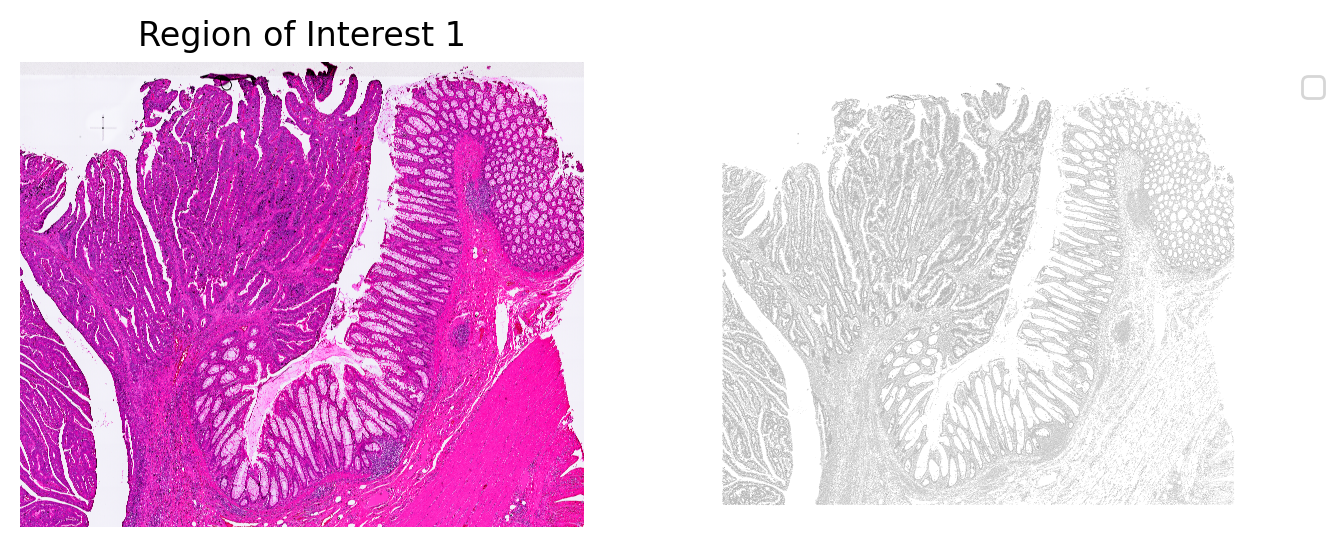

In [25]:
import image_plot_utils

# Reloading the module
importlib.reload(image_plot_utils)
from image_plot_utils import plot_mask_and_save_image
# Plot the nuclei segmentation
bbox=(last_barcode_pxl_row, first_barcode_pxl_col, first_barcode_pxl_row, last_barcode_pxl_col)

# Define a single color cmap
cmap=ListedColormap(['grey'])

# Create Plot
plot_mask_and_save_image(title="Region of Interest 1",gdf=gdf,bbox=bbox,cmap=cmap,img=img,output_name=dir_base+"image_mask.ROI1.tif")
